In [64]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib        as mpl
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics         import roc_curve

# Plot settings
mpl.rcParams['legend.frameon' ] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize' ] = 18
mpl.rcParams['axes.labelsize' ] = 18
mpl.rcParams['lines.linewidth'] = 2.5


# Useful functions
from utils import *

def remove_bjets_info(my_df):
    my_df = my_df.drop('nbjet',axis=1)
    jet_isb_list=['jet_isb'+str(i) for i in range(0,9)]
    my_df = my_df.drop(jet_isb_list,axis=1)
    return my_df

In [69]:
data = pd.read_csv('4topSM.csv')
df = pd.DataFrame(data)
#df = remove_bjets_info(df) #drop b-jets info as it is really chitting at the truth level
df = df[df['nlep']==1]
cols = df.columns.tolist()
cols = cols[1:-1] + [cols[0]]
df = df[cols]
df.head()

,ht,njet,nbjet,nlep,met,met_phi,lep_pt0,lep_pt1,lep_pt2,lep_pt3,...,jet_isb0,jet_isb1,jet_isb2,jet_isb3,jet_isb4,jet_isb5,jet_isb6,jet_isb7,jet_isb8,m4top
2,756.153748,9,5,1,51.067984,1.685508,125.348915,0.0,0.0,0.0,...,0,0,1,1,0,1,0,1,1,995.802801
7,784.967346,5,2,1,124.695771,2.699026,42.668476,0.0,0.0,0.0,...,0,0,1,1,0,0,0,0,0,997.258484
10,1031.466553,9,5,1,113.548479,1.358969,95.289795,0.0,0.0,0.0,...,0,0,1,1,0,1,0,1,1,1829.058990
11,906.050537,10,6,1,65.685084,-1.660739,44.110474,0.0,0.0,0.0,...,0,0,1,1,0,1,0,1,1,1671.732295
13,686.547058,9,5,1,123.047576,2.859429,31.058086,0.0,0.0,0.0,...,0,0,1,1,0,1,0,1,1,934.656048


In [70]:
data_ttV = pd.read_csv('ttV.csv')
df_ttV = pd.DataFrame(data_ttV)
#df_ttV = remove_bjets_info(df_ttV)
df_ttV = df_ttV[df_ttV['nlep']==1]
cols = df_ttV.columns.tolist()
cols = cols[1:-1] + [cols[0]]
df_ttV = df_ttV[cols]
df_ttV.head()

,ht,njet,nbjet,nlep,met,met_phi,lep_pt0,lep_pt1,lep_pt2,lep_pt3,...,jet_isb0,jet_isb1,jet_isb2,jet_isb3,jet_isb4,jet_isb5,jet_isb6,jet_isb7,jet_isb8,m4top
0,898.933899,8,4,1,22.632032,-0.086053,88.720406,0.0,0.0,0.0,...,1,0,1,0,0,0,1,1,0,-99.0
6,130.888138,1,0,1,147.211327,0.501316,37.027149,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,-99.0
7,976.115356,8,2,1,90.064838,-1.574606,44.923077,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,-99.0
10,944.330566,6,1,1,107.329650,1.086592,26.555531,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,-99.0
11,530.917114,3,1,1,19.012367,-2.784580,191.436264,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,-99.0


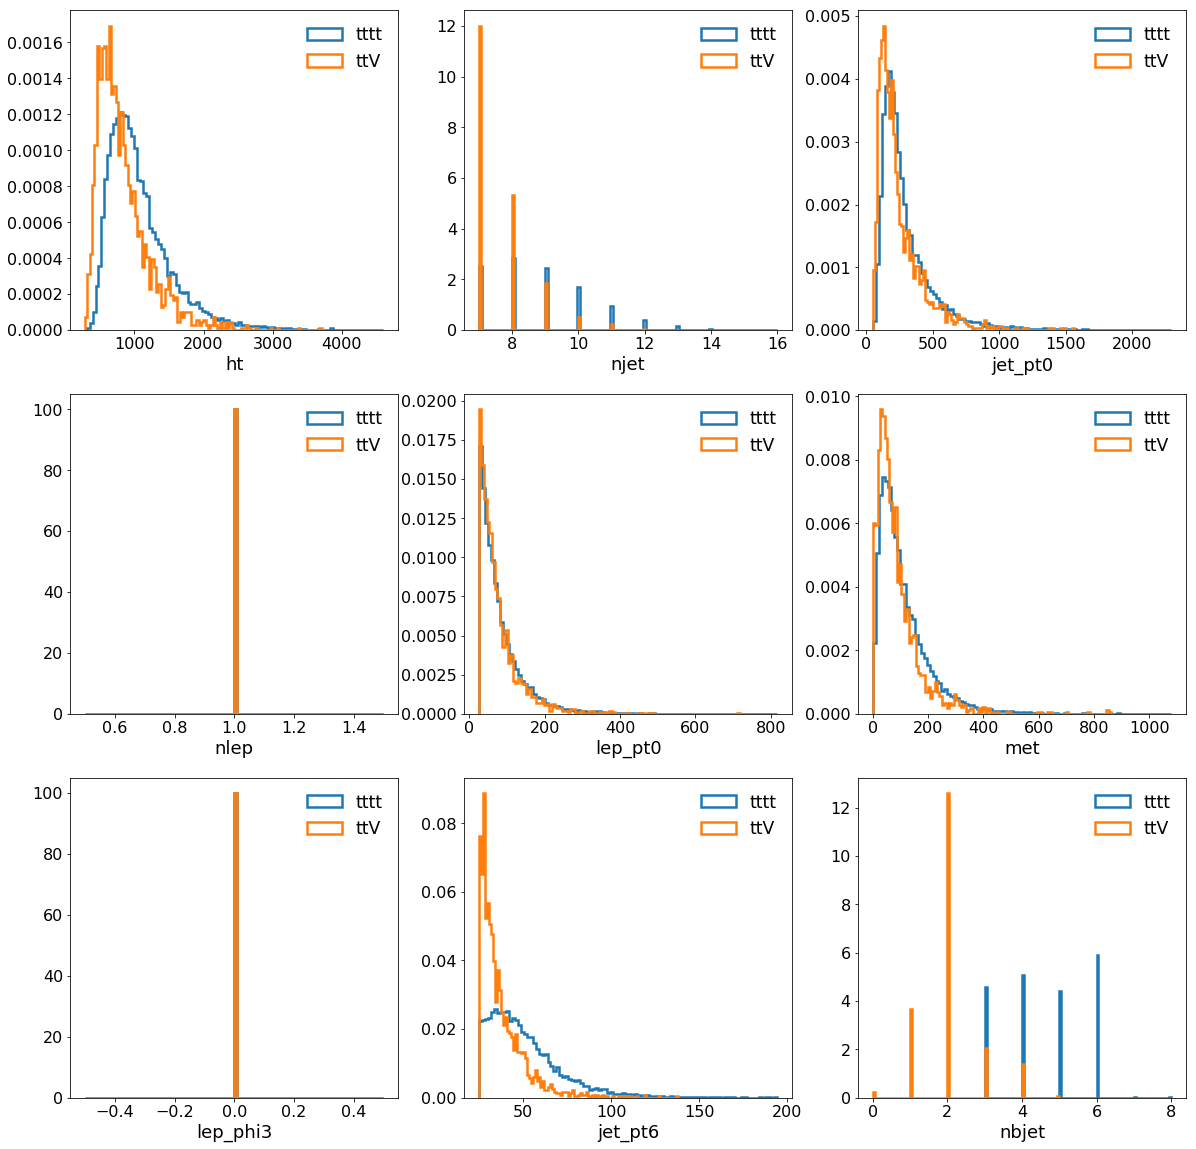

In [72]:
compare_4top_ttV_distributions(df[df['njet']>=7],df_ttV[df_ttV['njet']>=7],
                               ['ht','njet','jet_pt0','nlep','lep_pt0','met','lep_phi3','jet_pt6','nbjet'])

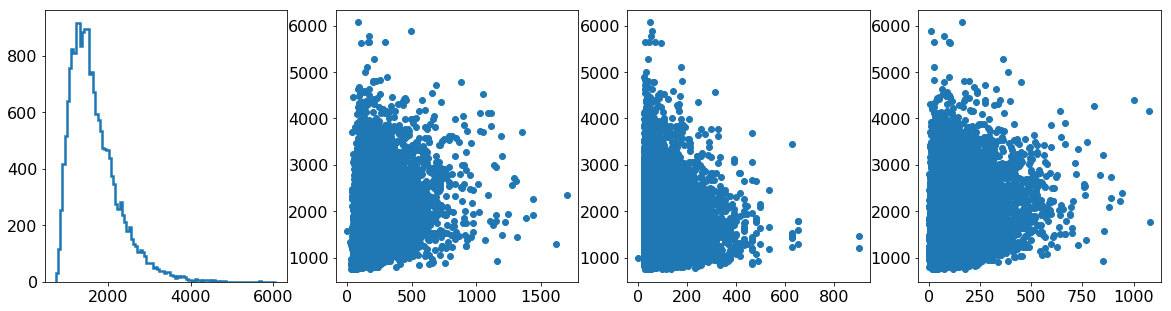

In [51]:
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.hist(df['m4top'], bins=100, histtype='step', linewidth=2.5,label='tttt')
plt.subplot(142)
plt.scatter(df['jet_pt1'],df['m4top'])
plt.subplot(143)
plt.scatter(df['lep_pt1'],df['m4top'])
plt.subplot(144)
plt.scatter(df['met'],df['m4top'])

In [6]:
# Features and target
dataX = df.drop('m4top',axis=1)
dataY = df['m4top']

# Preparing cross validation samples
trainX, testX, trainY, testY = train_test_split(dataX, dataY, random_state=42, train_size=0.5)

In [7]:
rf_regre = RandomForestRegressor(n_estimators=100,n_jobs=-1,max_depth=10).fit(trainX, trainY)

In [8]:
from sklearn.ensemble    import AdaBoostRegressor
from sklearn.tree        import DecisionTreeRegressor
ab_regre = AdaBoostRegressor(n_estimators=10, base_estimator=DecisionTreeRegressor(max_depth=10)).fit(trainX, trainY)

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
gb_regre = GradientBoostingRegressor(n_estimators=10, learning_rate=0.1, max_depth=10).fit(trainX,trainY)

In [10]:
#from xgboost.sklearn import XGBClassifier
#xgb_regre = XGBClassifier(n_estimators=10, learning_rate=0.1, max_depth=10).fit(trainX,trainY)

# --> eat too much memory and I am not sure why ...

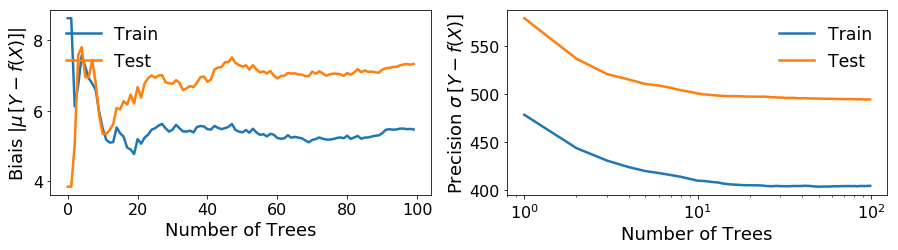

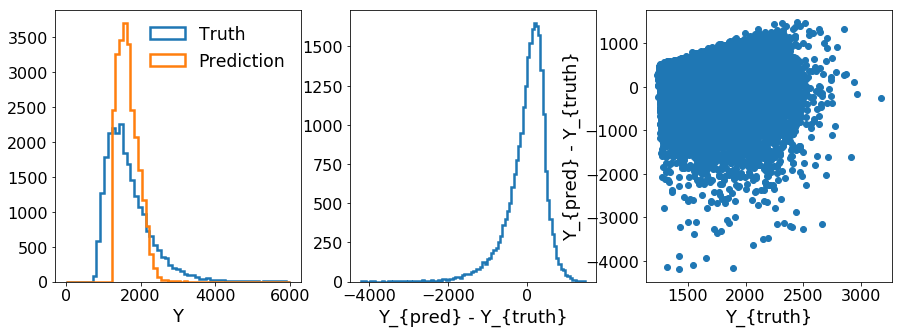

In [11]:
plot_perf_randomforest_vs_ntree(rf_regre,trainX,trainY,testX,testY)
plot_prediction_vs_truth(rf_regre,testX,testY)

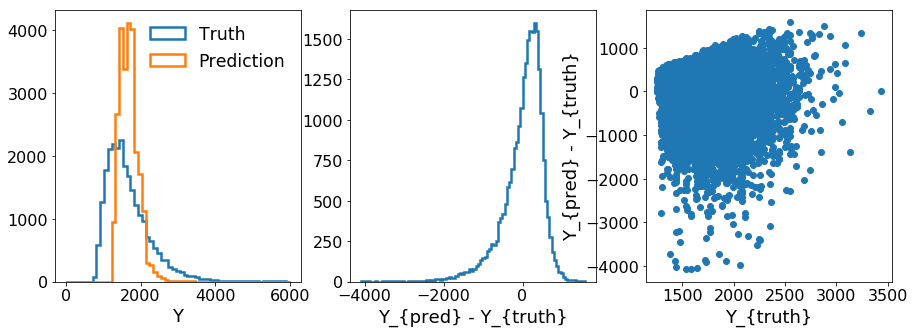

In [12]:
plot_prediction_vs_truth(ab_regre,testX,testY)

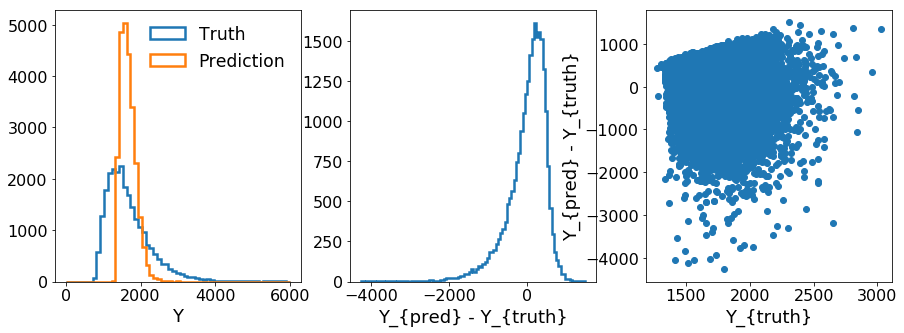

In [13]:
plot_prediction_vs_truth(gb_regre,testX,testY)

In [14]:
#plot_prediction_vs_truth(xgb_regre,testX,testY)

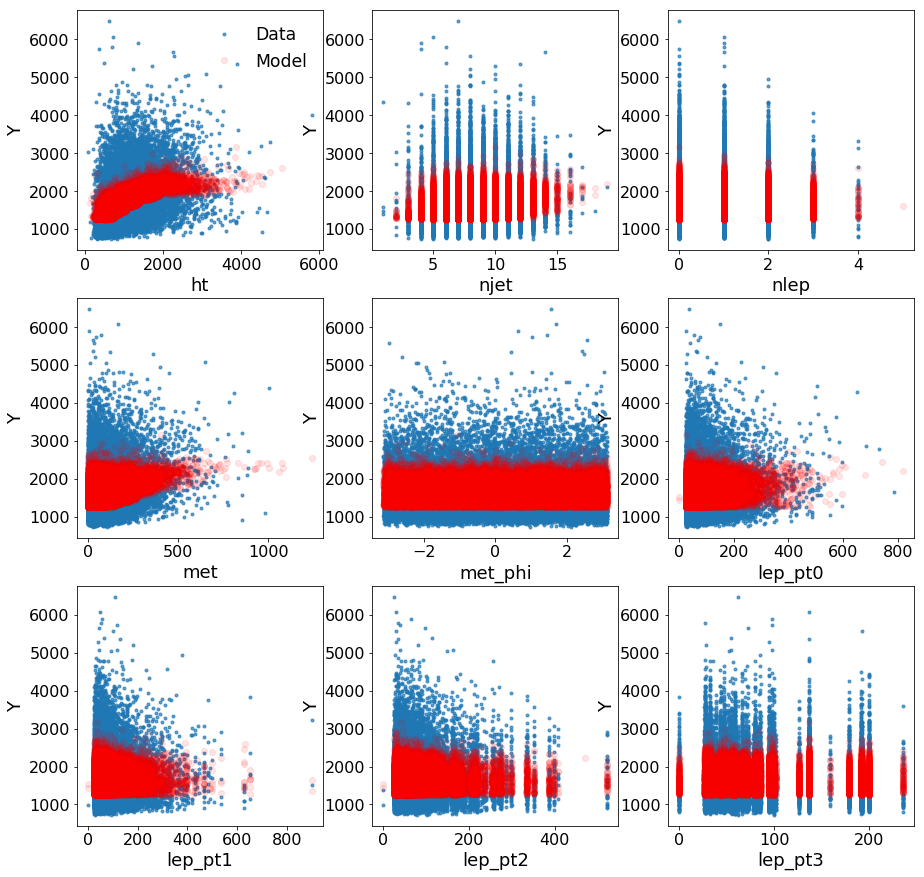

In [15]:
plot_prediction_ndim(rf_regre,testX,testY,trainX,trainY)

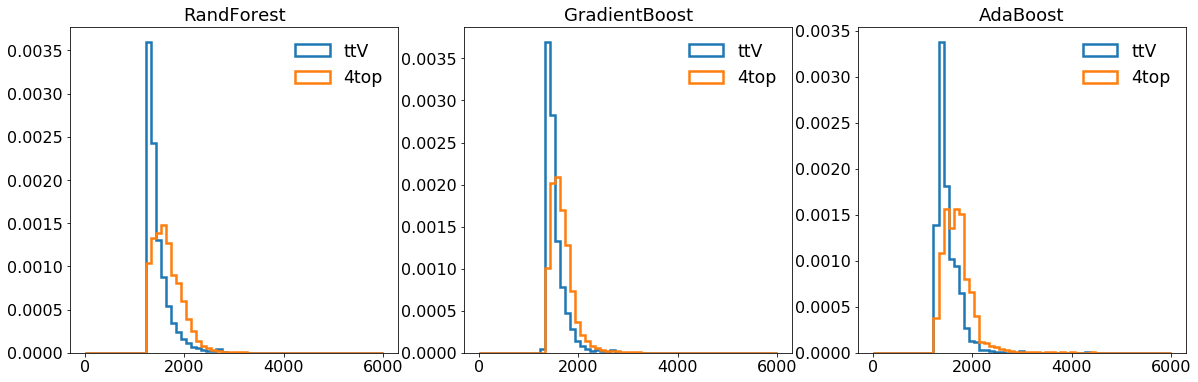

In [16]:
plt.figure(figsize=(20,6))
regressors=[[rf_regre,'RandForest'],[gb_regre,'GradientBoost'],[ab_regre,'AdaBoost']]
dataX_ttV = df_ttV.drop('m4top',axis=1)

i=0
for regre,name in regressors:
    i=i+1
    plt.subplot(1,3,i)
    plt.hist(regre.predict(dataX_ttV), density=True, bins=np.linspace(0,6000,60), histtype='step', linewidth=2.5, label='ttV')
    plt.hist(regre.predict(trainX)   , density=True, bins=np.linspace(0,6000,60), histtype='step', linewidth=2.5, label='4top')
    plt.title(name)
    plt.legend()

In [73]:
# Try classification
sig_labelled = df.drop(['m4top'],axis=1)
sig_labelled['isSig'] = 1
bkg_labelled = df_ttV.drop(['m4top'],axis=1)
bkg_labelled['isSig'] = 0
data  = pd.concat( [sig_labelled,bkg_labelled] )
dataX_clf = data.drop('isSig',axis=1)
dataY_clf = data['isSig']

#dataX_clf = dataX_clf[['ht','met','lep_pt3','jet_pt1','jet_pt6']]

# Preparing cross validation samples
trainX_clf, testX_clf, trainY_clf, testY_clf = train_test_split(dataX_clf, dataY_clf, random_state=42, train_size=0.5)

In [74]:
rf_clf = RandomForestRegressor(n_estimators=200,n_jobs=-1,max_depth=15).fit(trainX_clf, trainY_clf)

In [76]:
# look at the features importance
for feature, importance in zip(trainX_clf.columns,rf_clf.feature_importances_):
    print (feature, importance)

ht 0.00384253562418
njet 0.00617435080581
nbjet 0.0185367297353
nlep 0.0
met 0.00428894982678
met_phi 0.00172136034354
lep_pt0 0.00243002182688
lep_pt1 0.0
lep_pt2 0.0
lep_pt3 0.0
lep_pt4 0.0
lep_eta0 0.00170220724622
lep_eta1 0.0
lep_eta2 0.0
lep_eta3 0.0
lep_eta4 0.0
lep_phi0 0.00197320449357
lep_phi1 0.0
lep_phi2 0.0
lep_phi3 0.0
lep_phi4 0.0
jet_pt0 0.0021855940003
jet_pt1 0.00301453864499
jet_pt2 0.00221466059021
jet_pt3 0.00134060476729
jet_pt4 0.00350130048008
jet_pt5 0.00527418729408
jet_pt6 9.76823633668e-06
jet_pt7 5.63136345256e-06
jet_pt8 2.12862260685e-06
jet_pt9 0.0
jet_eta0 0.00218790981769
jet_eta1 0.00196335939085
jet_eta2 0.00144557742498
jet_eta3 0.00110579064163
jet_eta4 0.000485280998353
jet_eta5 7.03131704004e-06
jet_eta6 7.5694077599e-06
jet_eta7 5.75211690562e-06
jet_eta8 0.000103382373419
jet_eta9 7.87303950489e-07
jet_phi0 0.00228735717592
jet_phi1 0.00284167147709
jet_phi2 0.00153726068277
jet_phi3 0.00146434808379
jet_phi4 0.0007011050448
jet_phi5 0.00012138

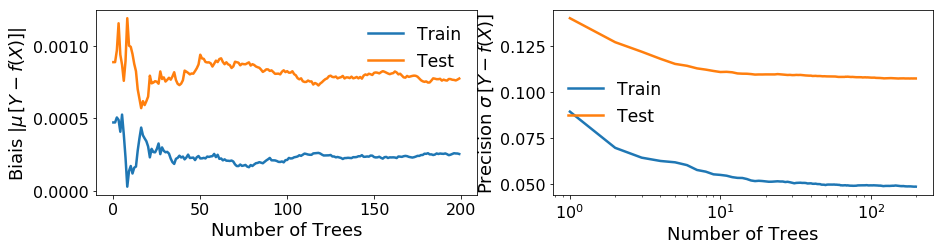

In [77]:
plot_perf_randomforest_vs_ntree(rf_clf,trainX_clf,trainY_clf,testX_clf,testY_clf)

Text(0.5,0,'Prediction of IsSignal')

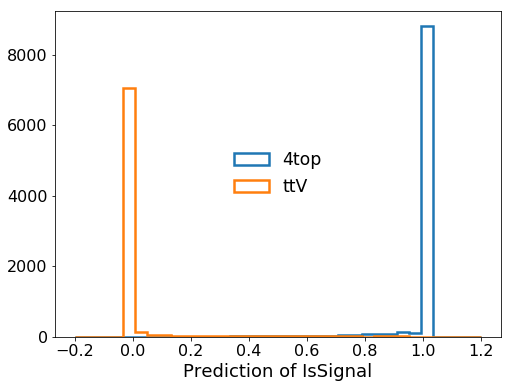

In [78]:
plt.figure(figsize=(8,6))
plt.hist(rf_clf.predict(testX_clf[testY_clf==1]), histtype='step', bins=np.linspace(-0.2,1.2,35), linewidth=2.5, label='4top')
plt.hist(rf_clf.predict(testX_clf[testY_clf==0]), histtype='step', bins=np.linspace(-0.2,1.2,35), linewidth=2.5, label='ttV')
plt.legend(loc='center')
plt.xlabel('Prediction of IsSignal')

In [15]:
VariableToTest   = ['ht','njet','lep_pt1','jet_pt1','jet_pt6']
RegressorsToTest = [[rf_regre,'RandForest (m4top)'],[ab_regre,'AdaBoost (m4top)'],[gb_regre,'GradientBoost (m4top)'],[rf_clf,'RandForest (classifier)']]
plot_roc_curves(df.drop('m4top',axis=1),df_ttV.drop('m4top',axis=1), VariableToTest, RegressorsToTest)

NameError: name 'rf_regre' is not defined